# Low-Dimensional Causal Effects (Self vs Neighbor)

This experiment studies a low-dimensional specification of causal effects on graphs. We constrain the attention mechanisms to depend only on a single covariate dimension (by default, the first feature of X) while keeping all other components unchanged.

What this notebook does
- Uses full X for data generation (treatment assignment and baseline outcome): simulate_treatment_linear_avg and get_base always use all features.
- Trains nuisance models (propensity, outcome mean) on full X.
- Restricts attention models to low dimension: when `low_dimension=True`, both the self effect g(X_i) and the neighbor attention f(X_i, X_j) depend only on the first feature of X.
- Reports individual effects:
  - Individual Main Effect (IME): direct self-treatment effect per node.
  - Individual Spillover Effect (ISE): neighbor-induced effect per node.
  - Individual Total Effect (ITE): IME + ISE.

How to use
- Set `low_dimension = True` in the config cell below to enable the low-dimensional attention specification for both self and neighbor effects.
- The rest of the pipeline (simulation, nuisance fitting, evaluation) remains identical.


In [19]:
import numpy as np
import torch
from utils import load_data, plot_true_vs_pred
from simulation import simulate_treatment, compute_outcome
from train import (
    GraphData,
    TrainConfig,
    PropensityConfig,
    MeanConfig,
    AttentionConfig,
    fit_propensity,
    fit_mean,
    fit_attention,
)
from metric import (
    compute_individual_effects,
    evaluate,
    compute_dbml_baseline,
)


### Config

In [22]:
# Config
path = "Flickr_New.npz"  # or "BC_New.npz"
feature_name = "lda_supervised"
fold_num = 2

# Outcome mode: "with_self" (current) or "separate_self" (new)
outcome_mode = "separate_self"  # change between "with_self" and "separate_self"
include_self_loop = (outcome_mode == "with_self")
low_dimension = True  # use only the first dimension of X for f and g

# Attention similarities
f_type = "cosine"  # neighbor attention f(X_i, X_j)
g_type = "heter"   # self treatment g(X_i) (used only in separate_self mode)
attn_temperature = 0

# Hyperparams
beta = 1
alpha = 2
sigma = 0.05
scale = 5
num_partition = 3

# Load data
X, A, X_val, A_val, X_test, A_test = load_data(path, feature_name, fold_num)


### Semi-synthetic data generation 

In [23]:
# Simulate treatment and outcome according to outcome_mode
nbrs_idx, n, d, partitions, t, e_star, treat_neighbor, treat_matrix = simulate_treatment(
    X, A, mode="train", beta=beta, alpha=alpha, num_partitions=num_partition, include_self_loop=include_self_loop
)

# Unified treatment/outcome
true_attention, spillover, U_0, noise, y, m_star, g_true = compute_outcome(
    X, A, treat_matrix, e_star, n, sigma, scale, attn_temperature, name=f_type,
    outcome_mode=outcome_mode, self_name=g_type, t=t, low_dimension=low_dimension
)

# Define IME/ISE/ITE for training via unified function
IME, ISE, ITE = compute_individual_effects(true_attention, A, outcome_mode=outcome_mode, g_self=g_true)

# test split
nbrs_idx_test, n_test, d_test, partitions_test, t_test, e_star_test, treat_neighbor_test, treat_matrix_test = simulate_treatment(
    X_test, A_test, mode="test", beta=beta, alpha=alpha, include_self_loop=include_self_loop
)
true_attention_test, spillover_test, U_0_test, noise_test, y_test, m_star_test, g_true_test = compute_outcome(
    X_test, A_test, treat_matrix_test, e_star_test, n_test, sigma, scale, attn_temperature, name=f_type,
    outcome_mode=outcome_mode, self_name=g_type, t=t_test, low_dimension=low_dimension
)

# Define IME/ISE/ITE for test via unified function
IME_test, ISE_test, ITE_test = compute_individual_effects(true_attention_test, A_test, outcome_mode=outcome_mode, g_self=g_true_test)



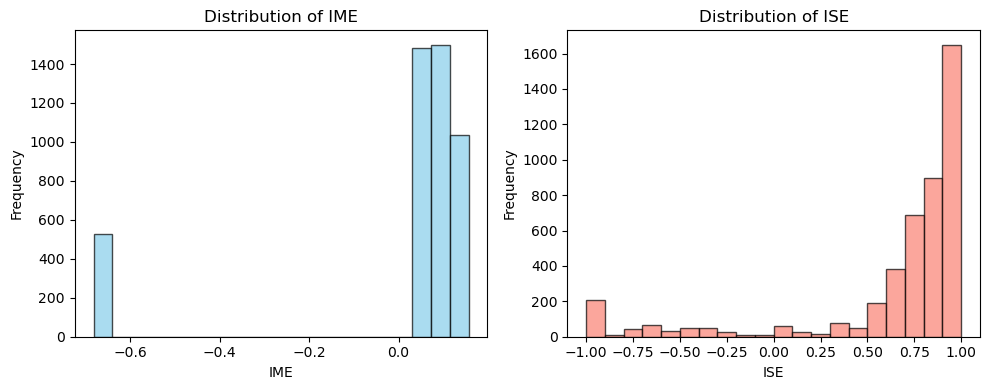

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(IME, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.title("Distribution of IME")
plt.xlabel("IME")
plt.ylabel("Frequency")

plt.subplot(1,2,2)
plt.hist(ISE, bins=20, alpha=0.7, color='salmon', edgecolor='black')
plt.title("Distribution of ISE")
plt.xlabel("ISE")
plt.ylabel("Frequency")
plt.tight_layout()

plt.show()

In [39]:
ISE[0:20]

array([ 0.86721144,  0.87363834,  0.75854214,  0.81447964,  0.84441939,
       -0.81406436,  0.85856079, -0.62637363,  0.86080586,  0.85636856,
        0.82510578,  0.88679245,  0.8115942 ,  0.88571429,  0.81039755,
        0.84568835,  0.86053883,  0.80981595,  0.87944359,  0.86645469])

### Fitting nuisance components

In [33]:
# Train configs
train_cfg_pm = TrainConfig(epochs=400, lr=1e-3, batch_size=64, patience=12, device="cpu", log_every=40)

prop_cfg = PropensityConfig(hidden_dim=128)
mean_cfg = MeanConfig(hidden_dim=128)

data = GraphData(X=X, y=y, A=A, nbrs_idx=nbrs_idx, t=t, fold_assignments=partitions)

fr_p, data = fit_propensity(data, train_cfg_pm, prop_cfg)
fr_m, data = fit_mean(data, train_cfg_pm, mean_cfg)

[propensity] Fold 0, Epoch 040 | train loss: 0.497628 | fold_loss: 0.487659
[propensity] Fold 0, Epoch 080 | train loss: 0.438341 | fold_loss: 0.421586
[propensity] Fold 0, Epoch 120 | train loss: 0.422573 | fold_loss: 0.401507
[propensity] Fold 0, Epoch 160 | train loss: 0.413747 | fold_loss: 0.389380
[propensity] Fold 0, Epoch 200 | train loss: 0.407640 | fold_loss: 0.381689
[propensity] Fold 0, Epoch 240 | train loss: 0.403551 | fold_loss: 0.377550
[propensity] Fold 0, Epoch 280 | train loss: 0.400719 | fold_loss: 0.375700
[propensity] Fold 0, Epoch 320 | train loss: 0.398622 | fold_loss: 0.375243
[propensity] Fold 0, Epoch 360 | train loss: 0.397011 | fold_loss: 0.375308
[propensity] Fold 0, Epoch 400 | train loss: 0.395711 | fold_loss: 0.375773
[propensity] Fold 1, Epoch 040 | train loss: 0.465017 | fold_loss: 0.473923
[propensity] Fold 1, Epoch 080 | train loss: 0.416986 | fold_loss: 0.431175
[propensity] Fold 1, Epoch 120 | train loss: 0.399940 | fold_loss: 0.421688
[propensity]

253.48354779923912
13.558659509608802


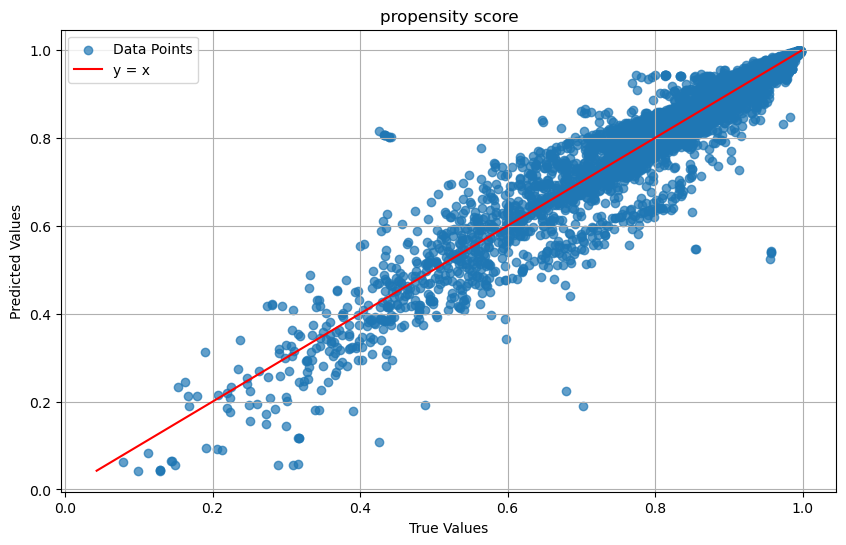

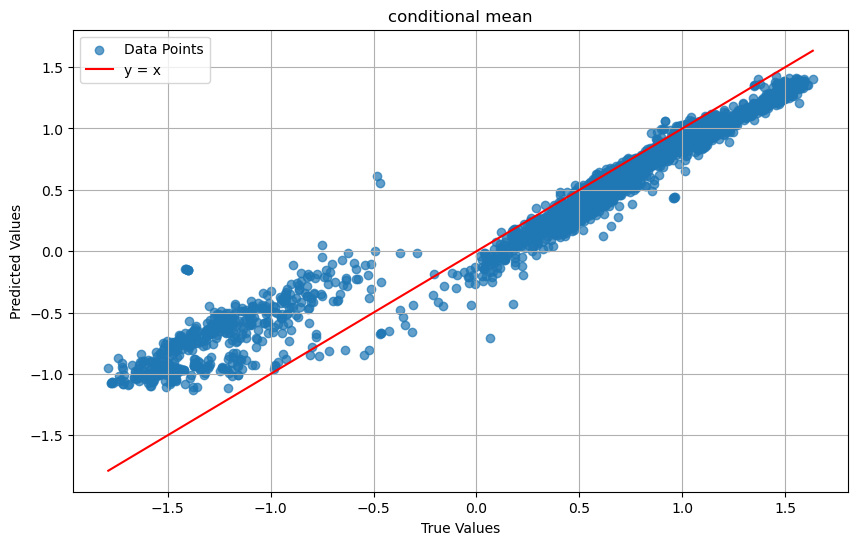

In [35]:
mu_hat = data.mu_hat
e_hat = data.e_hat

print(np.sum((mu_hat-m_star)**2))
print(np.sum((e_hat-e_star)**2))

plot_true_vs_pred(e_hat,e_star,title_name="propensity score")
plot_true_vs_pred(mu_hat,m_star,title_name="conditional mean")

### Fitting causal effect

In [36]:
# Fit attention
train_cfg_attn = TrainConfig(epochs=400, lr=1e-4, batch_size=64, patience=12, device="cpu", log_every=1)
# attention config switches model behavior
attn_cfg = AttentionConfig(hidden_dim=64, attn_temperature=attn_temperature, separate_self=(outcome_mode=="separate_self"), low_dimension=low_dimension)

# Single call: g_true is None in with_self, provided in separate_self
fr_a = fit_attention(data, train_cfg_attn, attn_cfg, attn_true=true_attention, attn_true_self=g_true)

print("Done fitting attention.")

Epoch 001, New best Spillover diff: 623.7539
Epoch 002, New best Spillover diff: 350.0329
Epoch 003, New best Spillover diff: 211.4857
Epoch 004, New best Spillover diff: 133.5786
Epoch 005, New best Spillover diff: 87.5188
Epoch 006, New best Spillover diff: 64.7190
Epoch 007, New best Spillover diff: 51.9287
Epoch 008, New best Spillover diff: 42.3508
Epoch 009, New best Spillover diff: 35.9905
Epoch 010, New best Spillover diff: 33.0226
Epoch 011, New best Spillover diff: 30.2853
Epoch 012, New best Spillover diff: 27.3584
Epoch 013, New best Spillover diff: 25.0660
Epoch 014, New best Spillover diff: 22.7841
No improve. Epoch 015, Spillover diff: 23.2532
Epoch 016, New best Spillover diff: 20.7438
Epoch 017, New best Spillover diff: 19.0038
No improve. Epoch 018, Spillover diff: 19.5180
No improve. Epoch 019, Spillover diff: 19.6420
Epoch 020, New best Spillover diff: 18.7963
Epoch 021, New best Spillover diff: 18.7307
No improve. Epoch 022, Spillover diff: 19.1218
Epoch 023, New b

Proposed: training set
IME: AME = -0.00757, PEHE = 0.00914
ISE: AME = 0.09460, PEHE = 0.14213
ITE: AME = 0.08703, PEHE = 0.13643
Proposed: testing set
IME: AME = -0.00782, PEHE = 0.00938
ISE: AME = 0.10252, PEHE = 0.14383
ITE: AME = 0.09470, PEHE = 0.13760


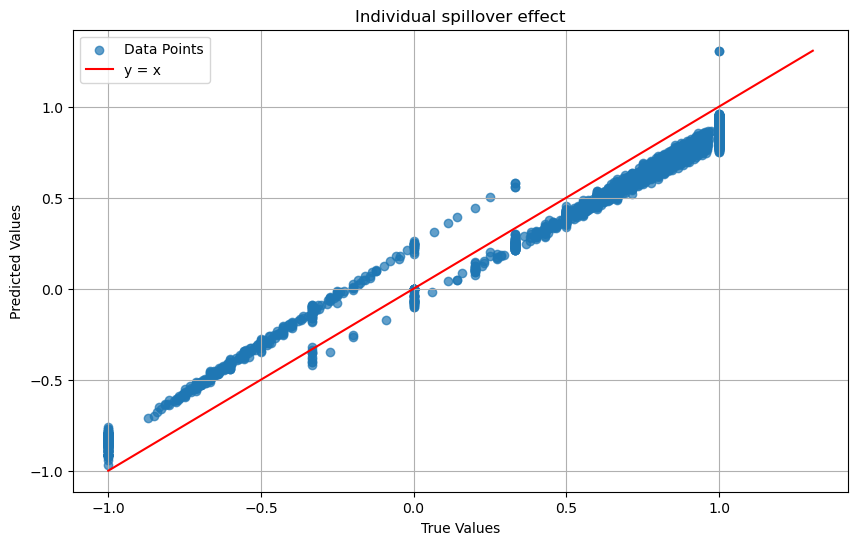

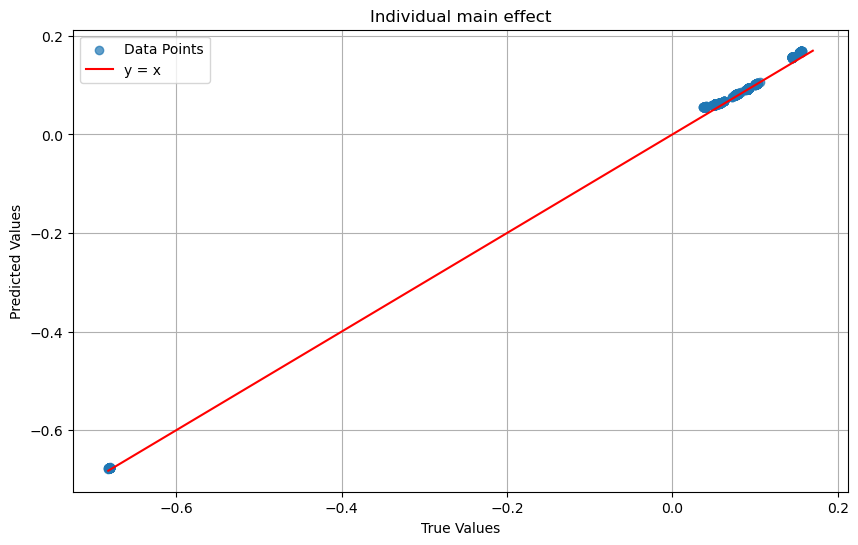

In [ ]:
# Unified estimation from model
with torch.no_grad():
  # Align X with model's expected input width (supports low_dimension)
  if hasattr(fr_a.model, 'self_mlp'):
    in_feats = int(fr_a.model.self_mlp[0].in_features)
  elif hasattr(fr_a.model, 'attention_mlp'):
    in_feats = max(1, int(fr_a.model.attention_mlp[0].in_features) // 2)
  else:
    in_feats = X.shape[1]
  X_used = torch.tensor(X[:, :in_feats], dtype=torch.float32)
  out = fr_a.model.cpu().predict(X_used, nbrs_idx, torch.tensor(t, dtype=torch.float32))
W_pred, g_pred = (out[0], out[2]) if isinstance(out, tuple) and len(out) == 3 else (out[0], None)
IME_est, ISE_est, ITE_est = compute_individual_effects(W_pred, A, outcome_mode, g_self=g_pred)
print("Proposed: training set")
Result_train=evaluate(IME, ISE, ITE, IME_est, ISE_est, ITE_est,printing=True)

with torch.no_grad():
  X_test_used = torch.tensor(X_test[:, :in_feats], dtype=torch.float32)
  out_test = fr_a.model.predict(X_test_used, nbrs_idx_test, torch.tensor(t_test, dtype=torch.float32))
W_pred_test, g_pred_test = (out_test[0], out_test[2]) if isinstance(out_test, tuple) and len(out_test) == 3 else (out_test[0], None)
IME_est_test, ISE_est_test, ITE_est_test = compute_individual_effects(W_pred_test, A_test, outcome_mode, g_self=g_pred_test)
print("Proposed: testing set")
Result_test=evaluate(IME_test, ISE_test, ITE_test, IME_est_test, ISE_est_test, ITE_est_test,printing=True)

plot_true_vs_pred(ISE,ISE_est,title_name="Individual spillover effect")
plot_true_vs_pred(IME,IME_est,title_name="Individual main effect")

# # DBML baseline: training set
# IME: AME = 0.06895, PEHE = 0.25423
# ISE: AME = 0.18507, PEHE = 0.54679
# ITE: AME = 0.25403, PEHE = 0.78033

### Compute baseline

In [40]:
# DBML baseline metric on training set
IME_db, ISE_db, ITE_db, beta_hat = compute_dbml_baseline(y, data.mu_hat, data.e_hat, A, n, t)
print("DBML baseline: training set")
_ = evaluate(IME, ISE, ITE, IME_db, ISE_db, ITE_db, printing=True)


DBML baseline: training set
IME: AME = 0.06895, PEHE = 0.25423
ISE: AME = 0.18507, PEHE = 0.54679
ITE: AME = 0.25403, PEHE = 0.78033
